In [ ]:
"""
This notebook is used to analyse the dino reconstruction loss and show images with highest and lowest dino reconstruction loss
at different token counts.
"""

'\nThis notebook is used to analyse the dino reconstruction loss\n'

In [3]:
import json
# add the parent directory to the Python path
import sys
import os
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
import matplotlib.pyplot as plt
import torch
from data.utils.dataloaders import get_imagenet_dataloader


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [5]:
# Paths (adjust if your files differ)
RECON_JSON = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json"

# Load reconstruction dataset (list of dicts with fields: image_id, k_value, vgg_error, mse_error, ...)
with open(RECON_JSON, 'r') as f:
    reconstruction_dataset = json.load(f)

print('Sizes:', len(reconstruction_dataset))
print('Sample entry:', reconstruction_dataset[0])

Sizes: 450000
Sample entry: {'image_id': 0, 'k_value': 1, 'L1Loss': 0.19351771473884583, 'LPIPS': 0.6646087765693665, 'LPIPS_layers': [0.11964087188243866, 0.14834865927696228, 0.11373482644557953, 0.1480303555727005, 0.13485409319400787], 'DINOv2FeatureLoss': 0.525488018989563}


In [6]:
# from data.utils.dataloaders import get_imagenet_dataloader
imagenet_val = get_imagenet_dataloader(split="val_categorized", batch_size=4)

In [7]:
# find image index with lowest and highest DINO loss
# the image_id is already stored in reconstruction_dataset entries
dino_losses = [[entry['image_id'], entry['DINOv2FeatureLoss'], entry["k_value"]] for entry in reconstruction_dataset]
dino_losses.sort(key=lambda x: x[1])  # sort by loss value
lowest_dino = dino_losses[0:10]
highest_dino = dino_losses[-10:]
print("Lowest DINO losses (image_id, loss, k_value):", lowest_dino)
print("Highest DINO losses (image_id, loss, k_value):", highest_dino)

Lowest DINO losses (image_id, loss, k_value): [[30210, 0.010271608829498291, 256], [30247, 0.01157158613204956, 256], [30215, 0.012044191360473633, 128], [26406, 0.012190461158752441, 256], [30210, 0.012470543384552002, 128], [38175, 0.012922525405883789, 256], [30238, 0.01315540075302124, 128], [39493, 0.013402700424194336, 256], [38150, 0.013408243656158447, 128], [38155, 0.013529181480407715, 256]]
Highest DINO losses (image_id, loss, k_value): [[34936, 1.117438554763794, 1], [5698, 1.1194791793823242, 1], [11355, 1.1203324794769287, 1], [10666, 1.1240266561508179, 1], [7654, 1.1313071250915527, 1], [13281, 1.1373507976531982, 1], [11651, 1.1408971548080444, 1], [9758, 1.144540548324585, 1], [9282, 1.1489628553390503, 1], [9738, 1.1576836109161377, 1]]


In [8]:
lowest_dino_img_indexes = [item[0] for item in lowest_dino]
highest_dino_img_indexes = [item[0] for item in highest_dino]

In [9]:
lowest_images = [imagenet_val.dataset[idx][0] for idx in lowest_dino_img_indexes]
highest_images = [imagenet_val.dataset[idx][0] for idx in highest_dino_img_indexes]

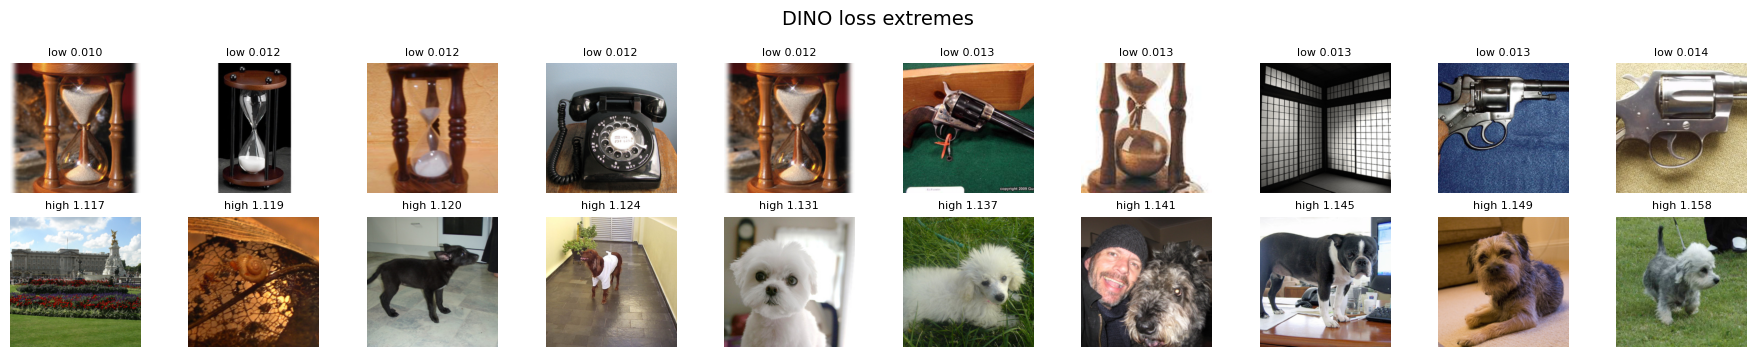

In [10]:
# Plot lowest vs highest DINO loss images (simple)
import math
num_low = len(lowest_images)
num_high = len(highest_images)
cols = max(num_low, num_high)
if cols == 0:
    print("No images to plot.")
else:
    fig, axes = plt.subplots(2, cols, figsize=(1.8*cols, 3.6))
    fig.suptitle("DINO loss extremes", fontsize=14)
    # First row: lowest
    for i in range(cols):
        ax = axes[0, i]
        ax.axis('off')
        if i < num_low:
            img = denormalize(lowest_images[i]).clamp(0, 1).permute(1, 2, 0).cpu()
            ax.imshow(img)
            loss_val = lowest_dino[i][1]
            ax.set_title(f"low {loss_val:.3f}", fontsize=8)
    # Second row: highest
    for i in range(cols):
        ax = axes[1, i]
        ax.axis('off')
        if i < num_high:
            img = denormalize(highest_images[i]).clamp(0, 1).permute(1, 2, 0).cpu()
            loss_val = highest_dino[i][1]
            ax.set_title(f"high {loss_val:.3f}", fontsize=8)
            ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [11]:
# Group entries by k_value for per-k plots
from collections import defaultdict

k_to_entries = defaultdict(list)  # k -> list of (image_id, dino_loss)
for e in reconstruction_dataset:
    try:
        k = int(e.get('k_value', -1))
    except Exception:
        continue
    img_id = e.get('image_id')
    loss = e.get('DINOv2FeatureLoss')
    if img_id is None or loss is None:
        continue
    k_to_entries[k].append((img_id, float(loss)))

ks_sorted = sorted(k_to_entries.keys())
print('k values found:', ks_sorted)

k values found: [1, 2, 4, 8, 16, 32, 64, 128, 256]


In [13]:
# Minimal resolver from image_id to dataset index
def _resolve_index(image_id):
    # Many pipelines store the dataset index as image_id; try to parse it
    try:
        return int(image_id)
    except Exception:
        return None

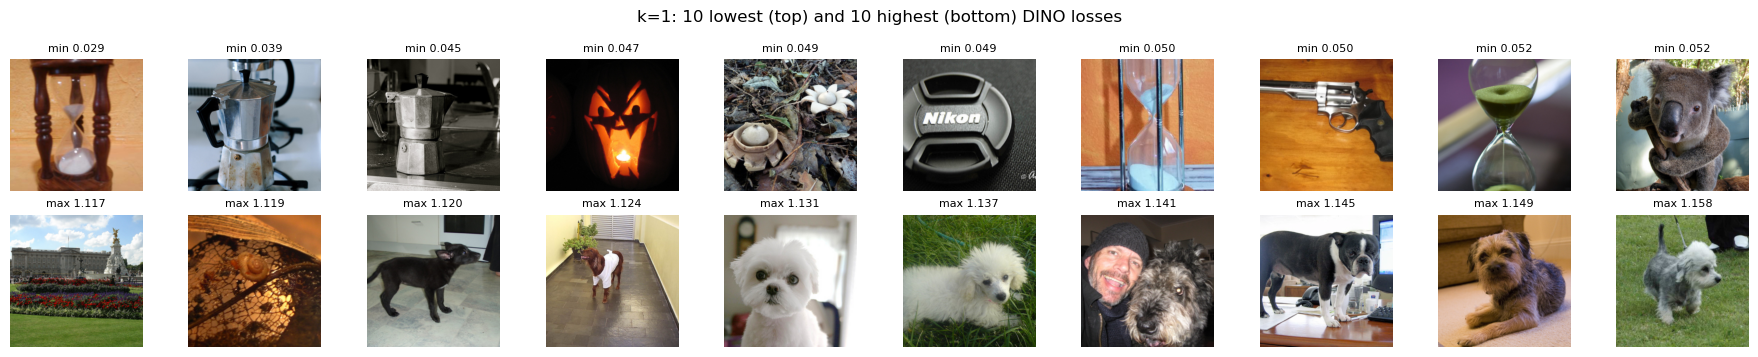

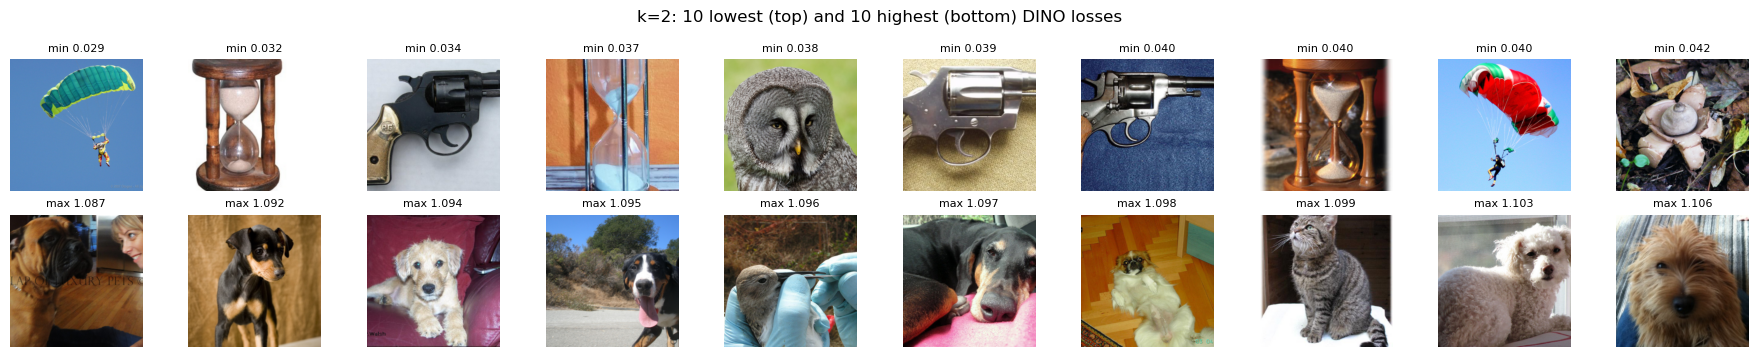

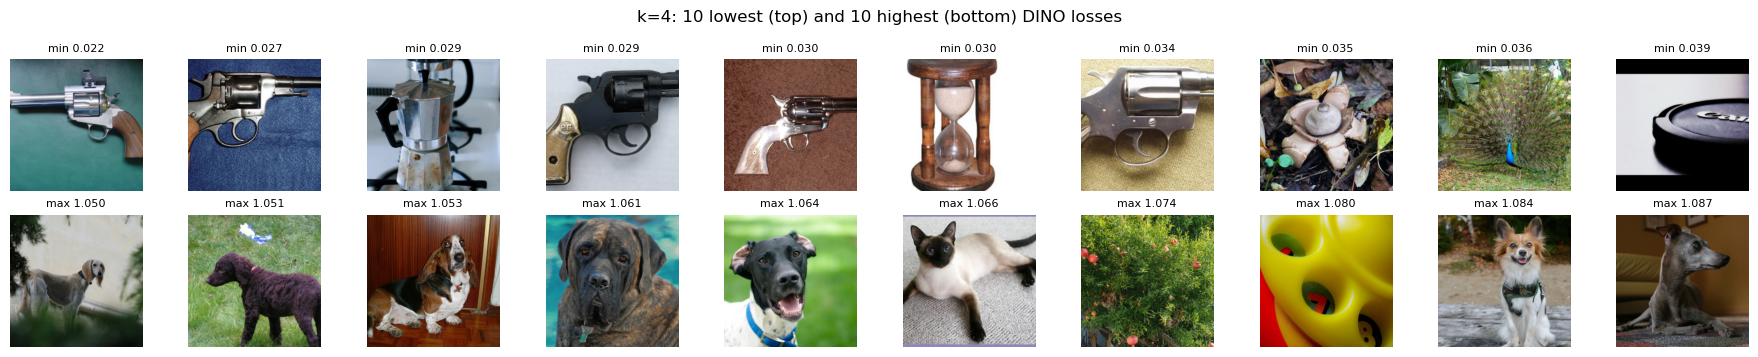

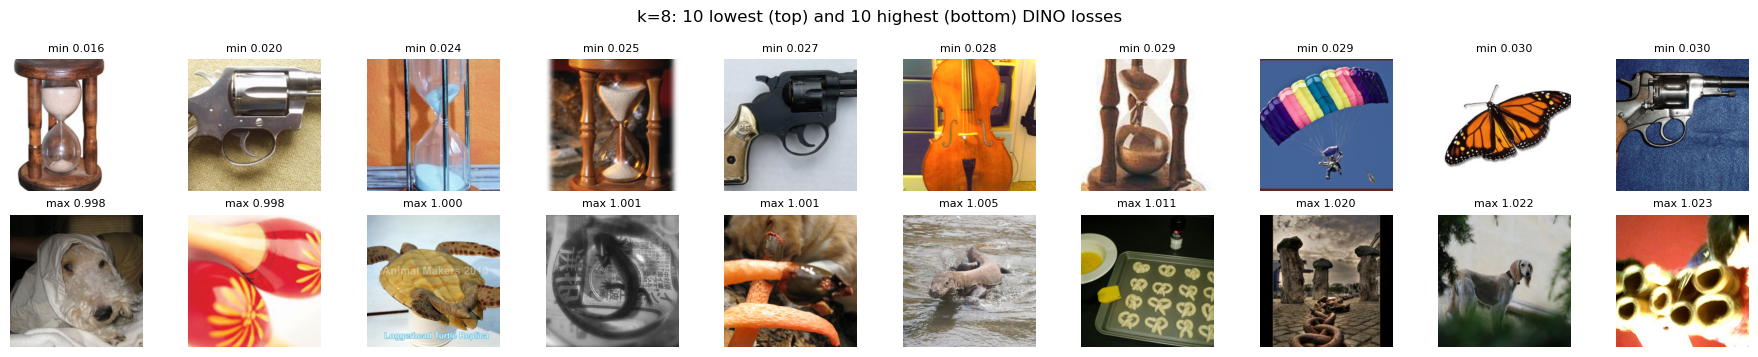

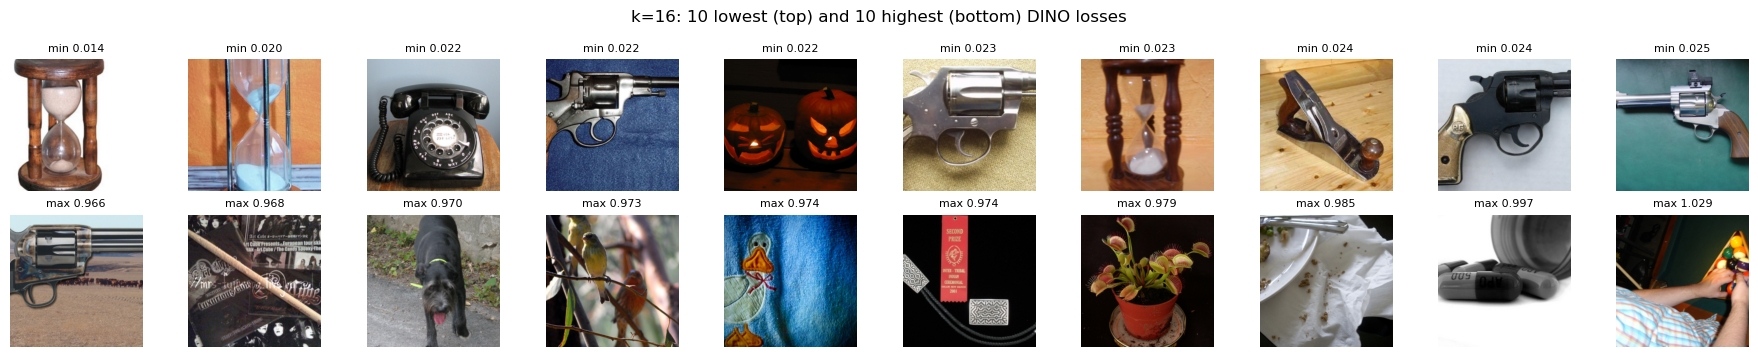

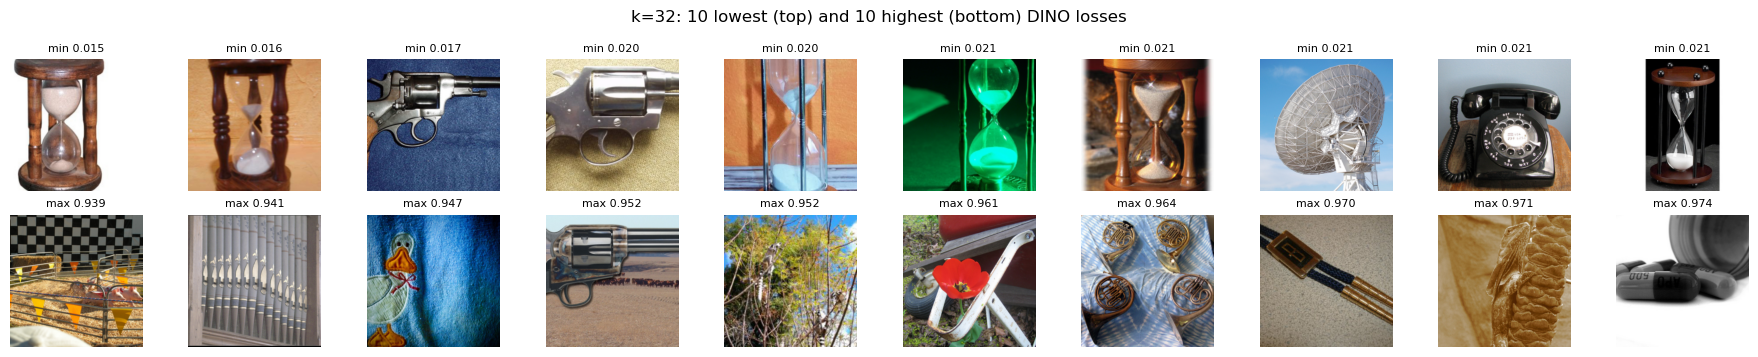

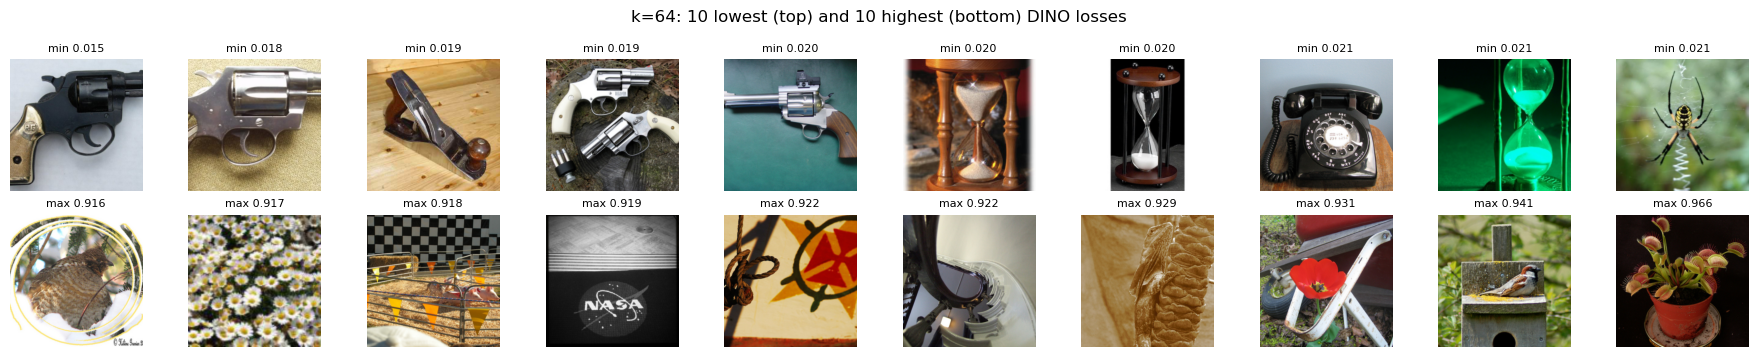

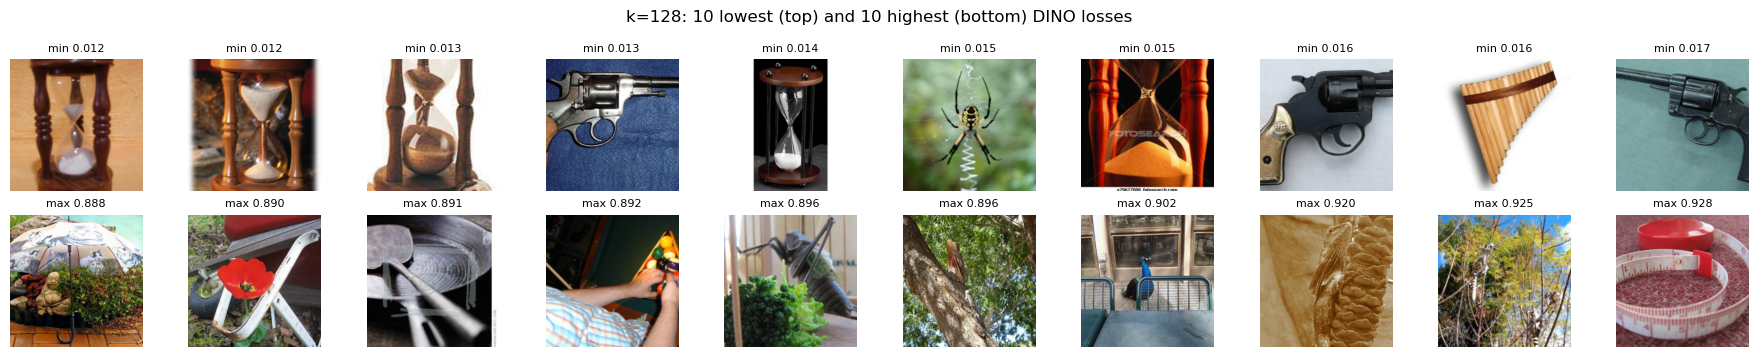

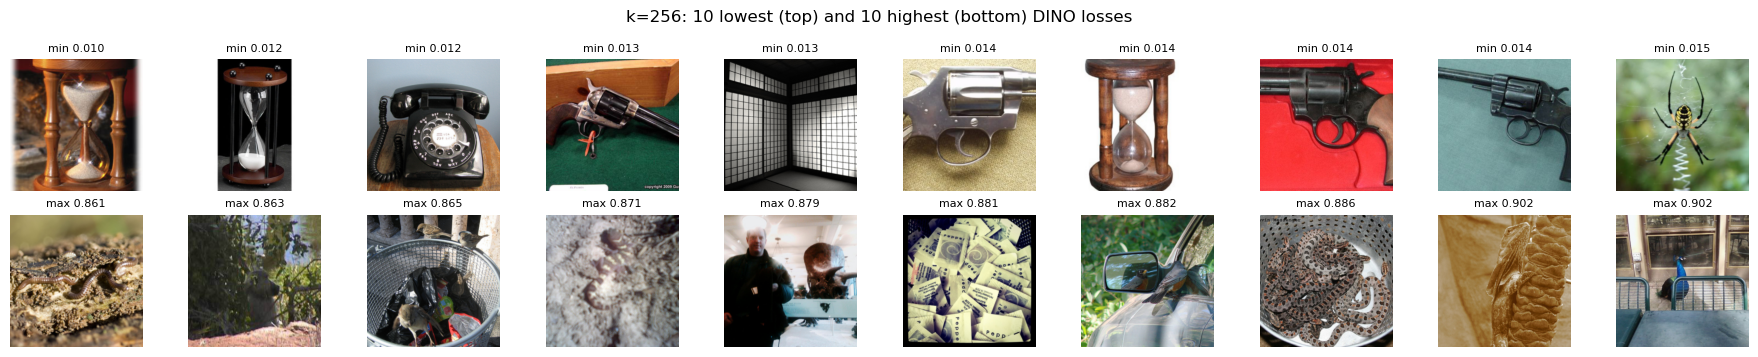

In [15]:
# Show 10 min and 10 max DINO loss images per k
import numpy as np

for k in ks_sorted:
    entries = k_to_entries.get(k, [])  # list of (image_id, loss)
    if not entries:
        print(f"k={k}: no entries.")
        continue
    # Sort by loss ascending
    entries_sorted = sorted(entries, key=lambda x: x[1])
    mins = entries_sorted[:10]
    maxs = entries_sorted[-10:]  # highest losses
    cols = max(len(mins), len(maxs))
    if cols == 0:
        print(f"k={k}: empty after filtering.")
        continue
    fig, axes = plt.subplots(2, cols, figsize=(1.8*cols, 3.6))
    if cols == 1:
        axes = np.array(axes).reshape(2, 1)
    fig.suptitle(f"k={k}: 10 lowest (top) and 10 highest (bottom) DINO losses", fontsize=12)
    # Top row: mins
    for j in range(cols):
        ax = axes[0, j]
        ax.axis('off')
        if j < len(mins):
            img_id, loss_val = mins[j]
            idx = _resolve_index(img_id)
            if idx is not None and 0 <= idx < len(imagenet_val.dataset):
                try:
                    img_t = imagenet_val.dataset[idx][0]  # CHW tensor (normalized)
                    img = denormalize(img_t).clamp(0, 1).permute(1, 2, 0).cpu()
                    ax.imshow(img)
                    ax.set_title(f"min {loss_val:.3f}", fontsize=8)
                except Exception as e:
                    ax.set_title(f"err: {e}", fontsize=8)
            else:
                ax.set_title(f"unresolved id {img_id}", fontsize=8)
    # Bottom row: maxs
    for j in range(cols):
        ax = axes[1, j]
        ax.axis('off')
        if j < len(maxs):
            img_id, loss_val = maxs[j]
            idx = _resolve_index(img_id)
            if idx is not None and 0 <= idx < len(imagenet_val.dataset):
                try:
                    img_t = imagenet_val.dataset[idx][0]
                    img = denormalize(img_t).clamp(0, 1).permute(1, 2, 0).cpu()
                    ax.imshow(img)
                    ax.set_title(f"max {loss_val:.3f}", fontsize=8)
                except Exception as e:
                    ax.set_title(f"err: {e}", fontsize=8)
            else:
                ax.set_title(f"unresolved id {img_id}", fontsize=8)
    plt.tight_layout()
    plt.show()